In [1]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
import lda
import os
import pdb
import nltk
import string
import json
import random
import pickle
import pandas as pd
import seaborn as sns
import scipy

from IPython.display import clear_output
from os import makedirs
from os.path import join, exists
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
logging.root.level = logging.INFO

In [3]:
INPUT_DIR = join('tmp', 'parsed')
OUTPUT_DIR = join('tmp')
makedirs(OUTPUT_DIR, exist_ok=True)

In [4]:
np.random.seed(1234)

In [5]:
from nltk.stem.porter import PorterStemmer

def tokenize(text):
    tokens = nltk.word_tokenize(text)
    stems = []
    for item in tokens:
        stems.append(PorterStemmer().stem(item))
    return stems

In [6]:
print("Building vocabulary...")

docs = {}
doc_tokens = {}
for fname in os.listdir(INPUT_DIR):
    if fname != '.DS_Store':
        with open(join(INPUT_DIR, fname), 'r') as f:
            doc = json.load(f)
            docs[doc['id']] = doc
            text = doc['body']
            table = str.maketrans({key: None for key in string.punctuation})
            text = text.lower().translate(table)
            doc_tokens[doc['id']] = text

token_keys = [x[0] for x in doc_tokens.items()]
token_values = [x[1] for x in doc_tokens.items()]
print(len(doc_tokens.items()))

Building vocabulary...
9086


# TF-IDF Vectorizer

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

print("Processing TF-IDF")

vectorizer = TfidfVectorizer(tokenizer=tokenize, norm='l2', stop_words='english')
X_tfidf = vectorizer.fit_transform(token_values)

print(X_tfidf.shape)

Processing TF-IDF
(9086, 141273)


# Add Keywords to docs

In [ ]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [ ]:
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    ''' Top tfidf features in specific document (matrix row) '''
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [ ]:
for i, key in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    docs[key]['keywords'] = top_feats_in_doc(X_tfidf, vectorizer.get_feature_names(), i, 10)
    
print(docs['2016-05-20-28']['keywords'])

# Add Vector to docs

In [ ]:
for i, key in enumerate(token_keys):
    docs[key]['tfidf'] = X_tfidf[i]

docs['2016-05-20-28']['tfidf']

# Save & Load Docs

In [150]:
pickle.dump(docs, open('tmp/docs.pickle', 'wb'))

In [8]:
docs = pickle.load(open('tmp/docs.pickle', 'rb'))

docs['2016-05-20-28'].keys()

dict_keys(['keywords', 'webTitle', 'ents', 'sectionId', 'id', 'body_t', 'webUrl', 'webPublicationDate', 'tfidf', 'authors', 'guardianId', 'apiUrl', 'body'])

# Build the graph from scratch

In [ ]:
g = ig.Graph()
for i, key in enumerate(token_keys):
    g.add_vertices(key)
    
print(g.vcount())

In [ ]:
g.delete_edges(g.es)
edges = []
for i, source in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    for j, target in enumerate(token_keys):
        edges.append((source, target))
            
g.add_edges(edges)  
edges = [] 
print(g.ecount())

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

count = 0
for i, source in enumerate(token_keys):
    similarities = cosine_similarity(X_tfidf[i], X_tfidf)[0]
    print('{0}\r'.format(i/len(token_keys)))
    clear_output(wait=True)
    for j, target in enumerate(token_keys):            
        g.es[count]["weight"] = similarities[j]
        count += 1

print(g.ecount())

Remove duplicated and self-loop edges

In [ ]:
g.simplify(multiple=True, loops=True, combine_edges="max")
print(g.ecount())

In [ ]:
g.es[1]['weight']

In [ ]:
g.write_gml('tmp/igraph.gml')

In [ ]:
g = ig.Graph.Read_GML('tmp/igraph.gml')

In [ ]:
sub_g = g.es.select(weight_ge=0.1).subgraph()

In [ ]:
print("Nodes {}".format(sub_g.vcount()))
print("Edges {}".format(sub_g.ecount()))

In [ ]:
print(sub_g.vs[1])
print(sub_g.vs[3])

In [ ]:
sub_g.write_gml('tmp/subgraph_01.gml')

# Load Network

In [9]:
g = ig.Graph.Read_GML('tmp/subgraph_01.gml')

In [10]:
def network_properties(g, community):
    print("Nodes {}".format(g.vcount()))
    print("Edges {}".format(g.ecount()))
#     print("Diameter {}".format(g.diameter()))
    print("LCC {}".format(g.clusters().giant().vcount()))
#     print("APL {}".format(g.average_path_length()))
#     print("AD {}".format(sum(g.degree())/len(g.degree())))
#     print("Giant Size {}".format(len(community.giant().vs())))
    print("NO of Communities {}".format(max(community.membership) + 1))
    print("Modularity {}".format(g.modularity(community.membership)))

In [11]:
threshold = np.average(cosine_similarity(X_tfidf))
threshold

0.032318418979897755

In [67]:
sg = g.es.select(weight_ge=0.1788).subgraph()

In [68]:
# community = sg.community_infomap(edge_weights='weight')
community = sg.community_multilevel(weights='weight')
# community = sg.community_leading_eigenvector(weights='weight')
network_properties(sg, community)

Nodes 8212
Edges 134587
LCC 7926
NO of Communities 150
Modularity 0.7770162025166544


# Complete Network (WIP)

In [135]:
sg1 = g.es.select(weight_ge=0.05).subgraph()
sg2 = g.es.select(weight_ge=0.2).subgraph()

In [136]:
# community = sg.community_infomap(edge_weights='weight')
community = sg1.community_multilevel(weights='weight')
# community = sg.community_leading_eigenvector(weights='weight')

In [137]:
network_properties(sg1, community)

Nodes 9086
Edges 6035451
LCC 9086
NO of Communities 8
Modularity 0.22018599699664898


In [138]:
ids = []
for v in sg2.vs:
    ids.append(v['id'])

vs = sg1.vs.select(id_notin=ids)
len(vs)

1272

In [140]:
for i, v in enumerate(vs):
    print('{0}\r'.format(i/len(vs)))
    clear_output(wait=True)
    es = sg1.es.select(_source=v['id'])
    
    try:
        max_value = max(es['weight'])
        max_index = es['weight'].index(max_value)
        source = sg1.vs[es[max_index].source]['name']
        target = sg1.vs[es[max_index].target]['name']
        try:
            sg2.vs().find(name=source)
        except:
            sg2.add_vertex(source)
        try:
            sg2.vs().find(name=target)
        except:
            sg2.add_vertex(target)
        sg2.add_edge(source, target, weight=es[max_index]['weight'])
    except:
        try:
            sg2.vs().find(name=v['name'])
        except:
            sg2.add_vertex(v['name'])
        next

0.9992138364779874


In [141]:
community = sg2.community_multilevel(weights='weight')

In [142]:
network_properties(sg2, community)

Nodes 9086
Edges 99430
LCC 8521
NO of Communities 232
Modularity 0.8272348058275936


In [149]:
pickle.dump(sg2, open('tmp/subgraph_02m.pickle', 'wb'))

## Show contents of communities

In [21]:
with open('tmp/network_docs.txt', 'w+') as file:
    for i in range(max(community.membership) + 1):
        for v in community.subgraph(i).vs():
            file.write("Topic:{} File:{} Title:{}\n".format(i, v['name'], docs[v['name']]['webTitle']))

# Network Size Chart

In [88]:
def network_to_topics(com):
    topics = {}

    for i in range(max(com.membership) + 1):
        for v in com.subgraph(i).vs():
            topic_no = i
            try:
                topics[topic_no]
            except KeyError:
                topics[topic_no] = []

            topics[topic_no].append(v['name'])
    
    net_topics = {}
    count = 1
    for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
        net_topics[count] = value
        count += 1
        
    return net_topics

In [89]:
def community_to_size_chart(net_topics):
    x_data = []
    y_data = []
    for key, value in net_topics.items():
        x_data.append(key)
        y_data.append(len(value))

    ind = np.arange(0, len(y_data) * 2, 2)
    fig = plt.figure(figsize=(60,10))
    plt.bar(ind, y_data)
    plt.xticks(ind, x_data, rotation=90)
    plt.title("Topic Document Distribution")
    plt.xlabel("Topic")
    plt.ylabel("Frequency")
    fig.savefig('tmp/size_chart_net.png')
    plt.show()

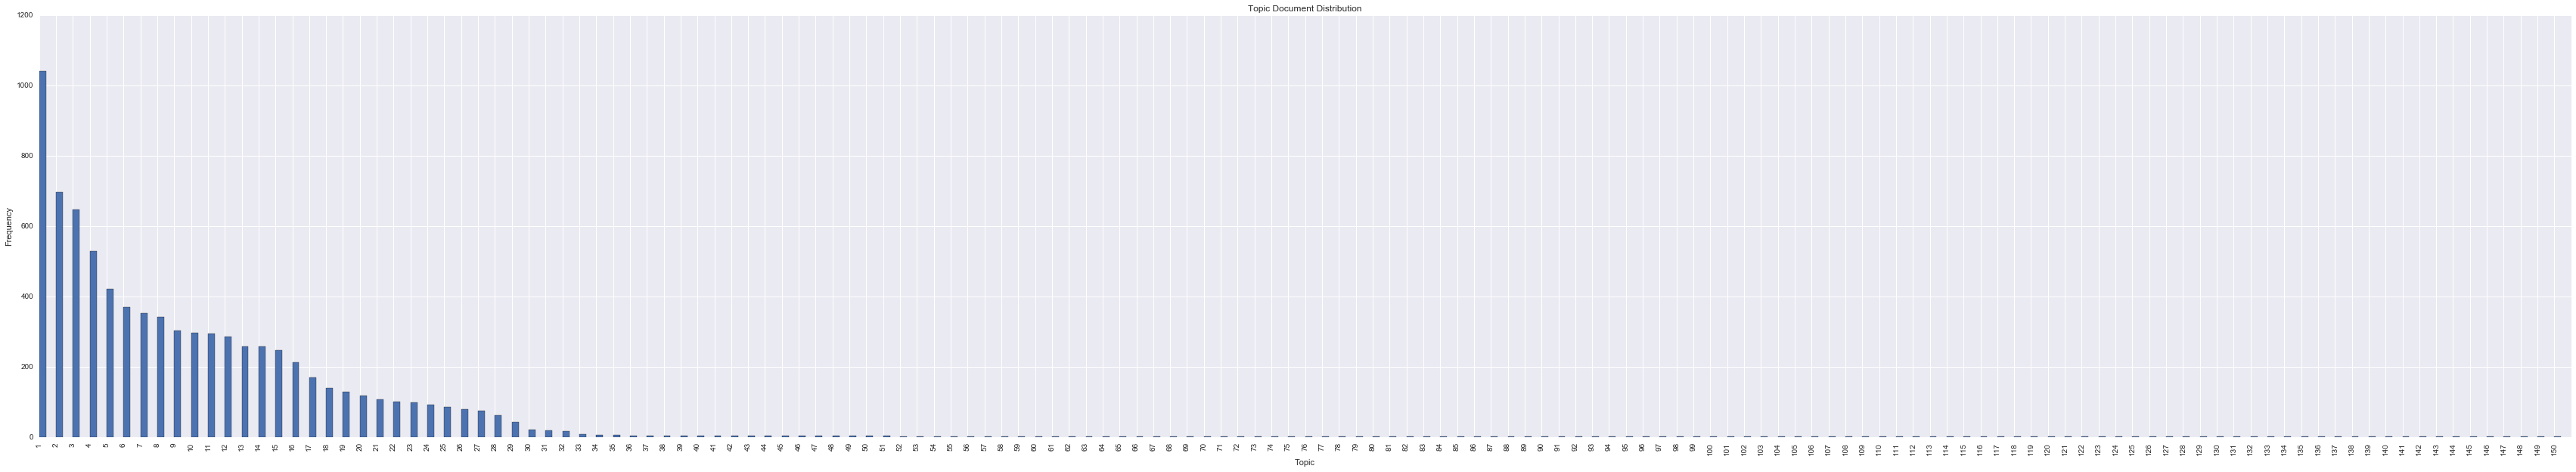

In [90]:
net_topics = network_to_topics(community)
community_to_size_chart(net_topics)

(array([ 0.86      ,  0.03333333,  0.05333333,  0.02      ,  0.00666667,
         0.00666667,  0.01333333,  0.        ,  0.        ,  0.00666667]),
 array([    2. ,   105.9,   209.8,   313.7,   417.6,   521.5,   625.4,
          729.3,   833.2,   937.1,  1041. ]),
 <a list of 10 Patch objects>)

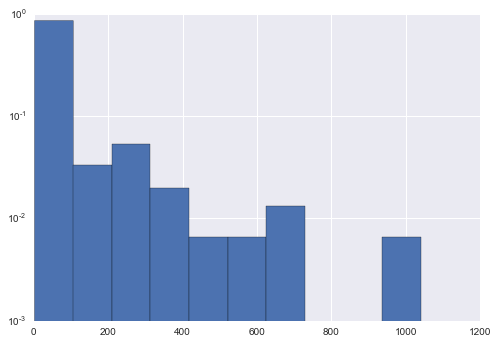

In [178]:
import scipy.stats as stats

x_data = []
y_data = []
for key, value in net_topics.items():
    x_data.append(key)
    y_data.append(len(value))
    
df = pd.DataFrame(y_data)
# df.hist(weights=np.ones_like(df[df.columns[0]]*100.)/len(df))

plt.hist(df, log=True, weights=np.ones_like(df[df.columns[0]]*100.)/len(df))

# LDA

In [24]:
from gensim import matutils
from gensim.models.ldamodel import LdaModel

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

print("Processing Count")

vectorizer = CountVectorizer(tokenizer=tokenize, stop_words='english')
X_count = vectorizer.fit_transform(token_values)

print(X_count.shape)

Processing Count
(9086, 141273)


In [28]:
vocab = vectorizer.get_feature_names()

## Run LDA

In [40]:
np.random.seed(1234)

gensim_model = LdaModel(matutils.Sparse2Corpus(X_count.T), 
                num_topics=150,
                passes=100,
                id2word=dict([(i, s) for i, s in enumerate(vocab)]))

In [41]:
pickle.dump(gensim_model, open('tmp/gensim_lda_150_100.pickle', 'wb'))

## Load LDA

In [25]:
lda_model = pickle.load(open('tmp/gensim_lda_150_50.pickle', 'rb'))

In [42]:
doc_topic_prob_mat = lda_model[matutils.Sparse2Corpus(X_count.T)]
print(len(doc_topic_prob_mat))

9086


In [43]:
for i, mat in enumerate(doc_topic_prob_mat):
    print('{0}\r'.format(i/len(doc_topic_prob_mat)))
    max_prob = max(mat, key=lambda x: x[1])
    docs[token_keys[i]]['lda'] = max_prob[0]
    docs[token_keys[i]]['lda_value'] = max_prob[1]
    clear_output(wait=True)

lda_items = sorted(docs.items(), key=lambda x: x[1]['lda'])

0.9998899405679067


In [44]:
d = list(map(lambda x: x[1]['lda_value'], docs.items()))

In [47]:
sum(1 for x in d if x >= 0.5)

800

In [51]:
pickle.dump(lda_items, open('tmp/lda_items.pickle', 'wb'))

In [49]:
with open('tmp/lda_docs.txt', 'w+') as file:
    for item in lda_items:
        file.write("Topic:{} File:{} Title:{}\n".format(item[1]['lda'], item[0], item[1]['webTitle']))

# LDA Size Chart

In [80]:
def lda_to_topics(lda_items):
    topics = {}

    for i in range(150):
        topics[i] = []

    for item in lda_items:
        topic_no = item[1]['lda']
        topics[topic_no].append(item[0])

    lda_topics = {}
    count = 1
    for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
        lda_topics[count] = value
        count += 1
        
    return lda_topics

In [81]:
def lda_to_size_chart(lda_topics):
    print(len(lda_topics.keys()))

    x_data = []
    y_data = []
    for key, value in lda_topics.items():
        x_data.append(key)
        y_data.append(len(value))

    ind = np.arange(0, len(y_data) * 2, 2)
    fig = plt.figure(figsize=(60,10))
    plt.bar(ind, y_data)
    plt.xticks(ind, x_data, rotation=90)
    plt.title("LDA Topic Document Distribution")
    plt.xlabel("Topic")
    plt.ylabel("Frequency")
    fig.savefig('tmp/size_chart_lda.png')
    plt.show()

150


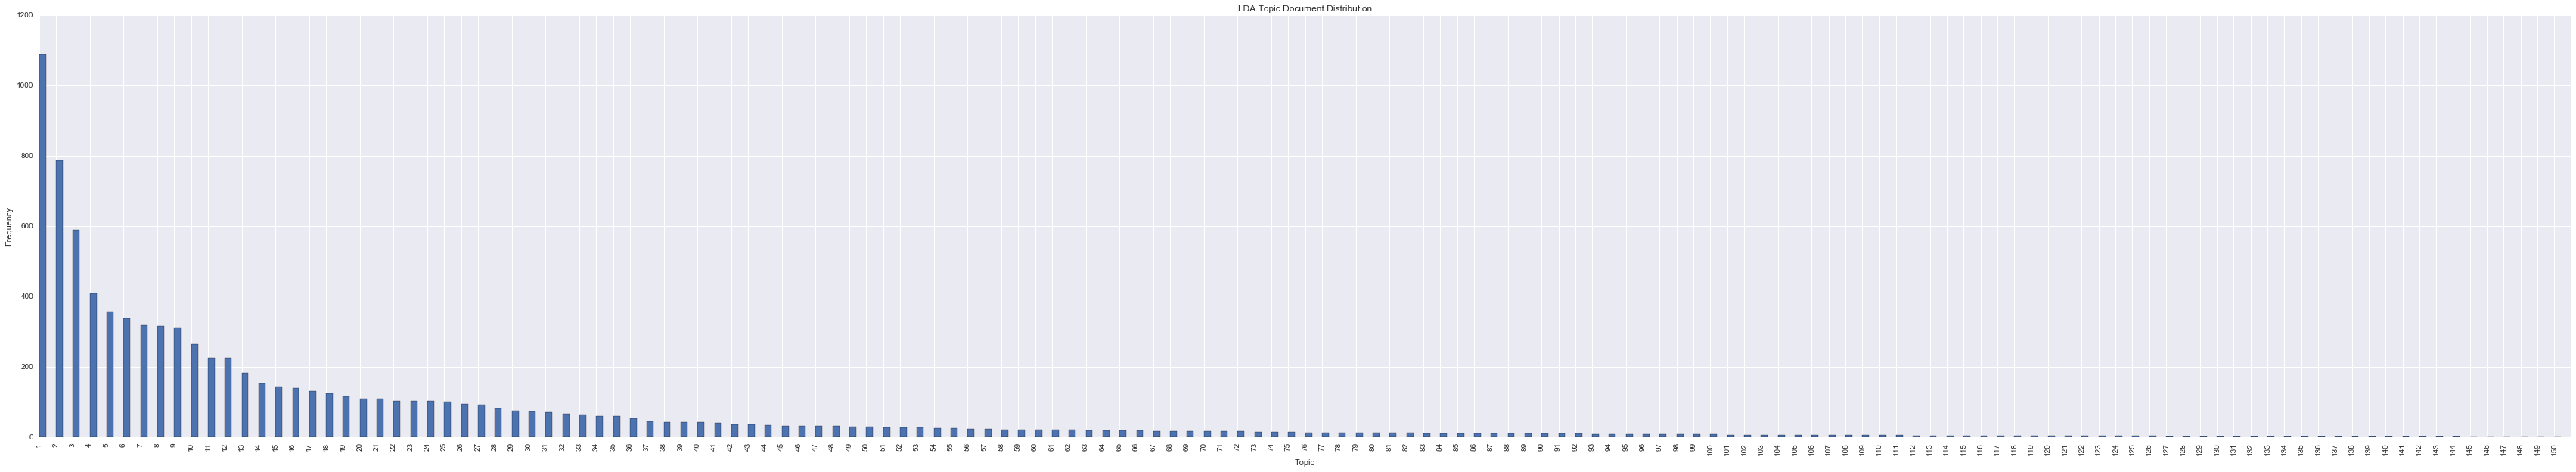

In [82]:
lda_items = pickle.load(open('tmp/lda_items.pickle', 'rb'))
lda_topics = lda_to_topics(lda_items)
lda_to_size_chart(lda_topics)

# Heatmap

In [95]:
def community_to_heatmap_data(network_topics):
    d = []
    for key, value in sorted(network_topics.items(), key=lambda x: x[0]):
        h = {}
        for v in value:
            h[v] = True
        d.append(h)

    return(d)

In [96]:
def lda_topics_to_heatmap_data(lda_topics):
    d = []
    for key, value in sorted(lda_topics.items(), key=lambda x: x[0]):
        h = {}
        for v in value:
            h[v] = True
        d.append(h)
        
    return d

In [97]:
net_data = community_to_heatmap_data(net_topics)
#lda_data = community_to_heatmap_data(community_lda)
lda_data = lda_topics_to_heatmap_data(lda_topics)

In [98]:
from sklearn.feature_extraction import DictVectorizer

vectorizer = DictVectorizer()
vectors  = net_data + lda_data
X_dict = vectorizer.fit_transform(vectors)

print(X_dict.shape)

(300, 9086)


In [100]:
print(len(net_data[0].keys()))
print(len(lda_data[0].keys()))
print(np.count_nonzero(X_dict[:150].toarray()[0]))

1041
1088
1041


In [101]:
net_vectors = X_dict[:150]
lda_vectors = X_dict[150:]

In [102]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(net_vectors, lda_vectors)

In [103]:
pickle.dump(similarities, open('tmp/similarities.pickle', 'wb'))

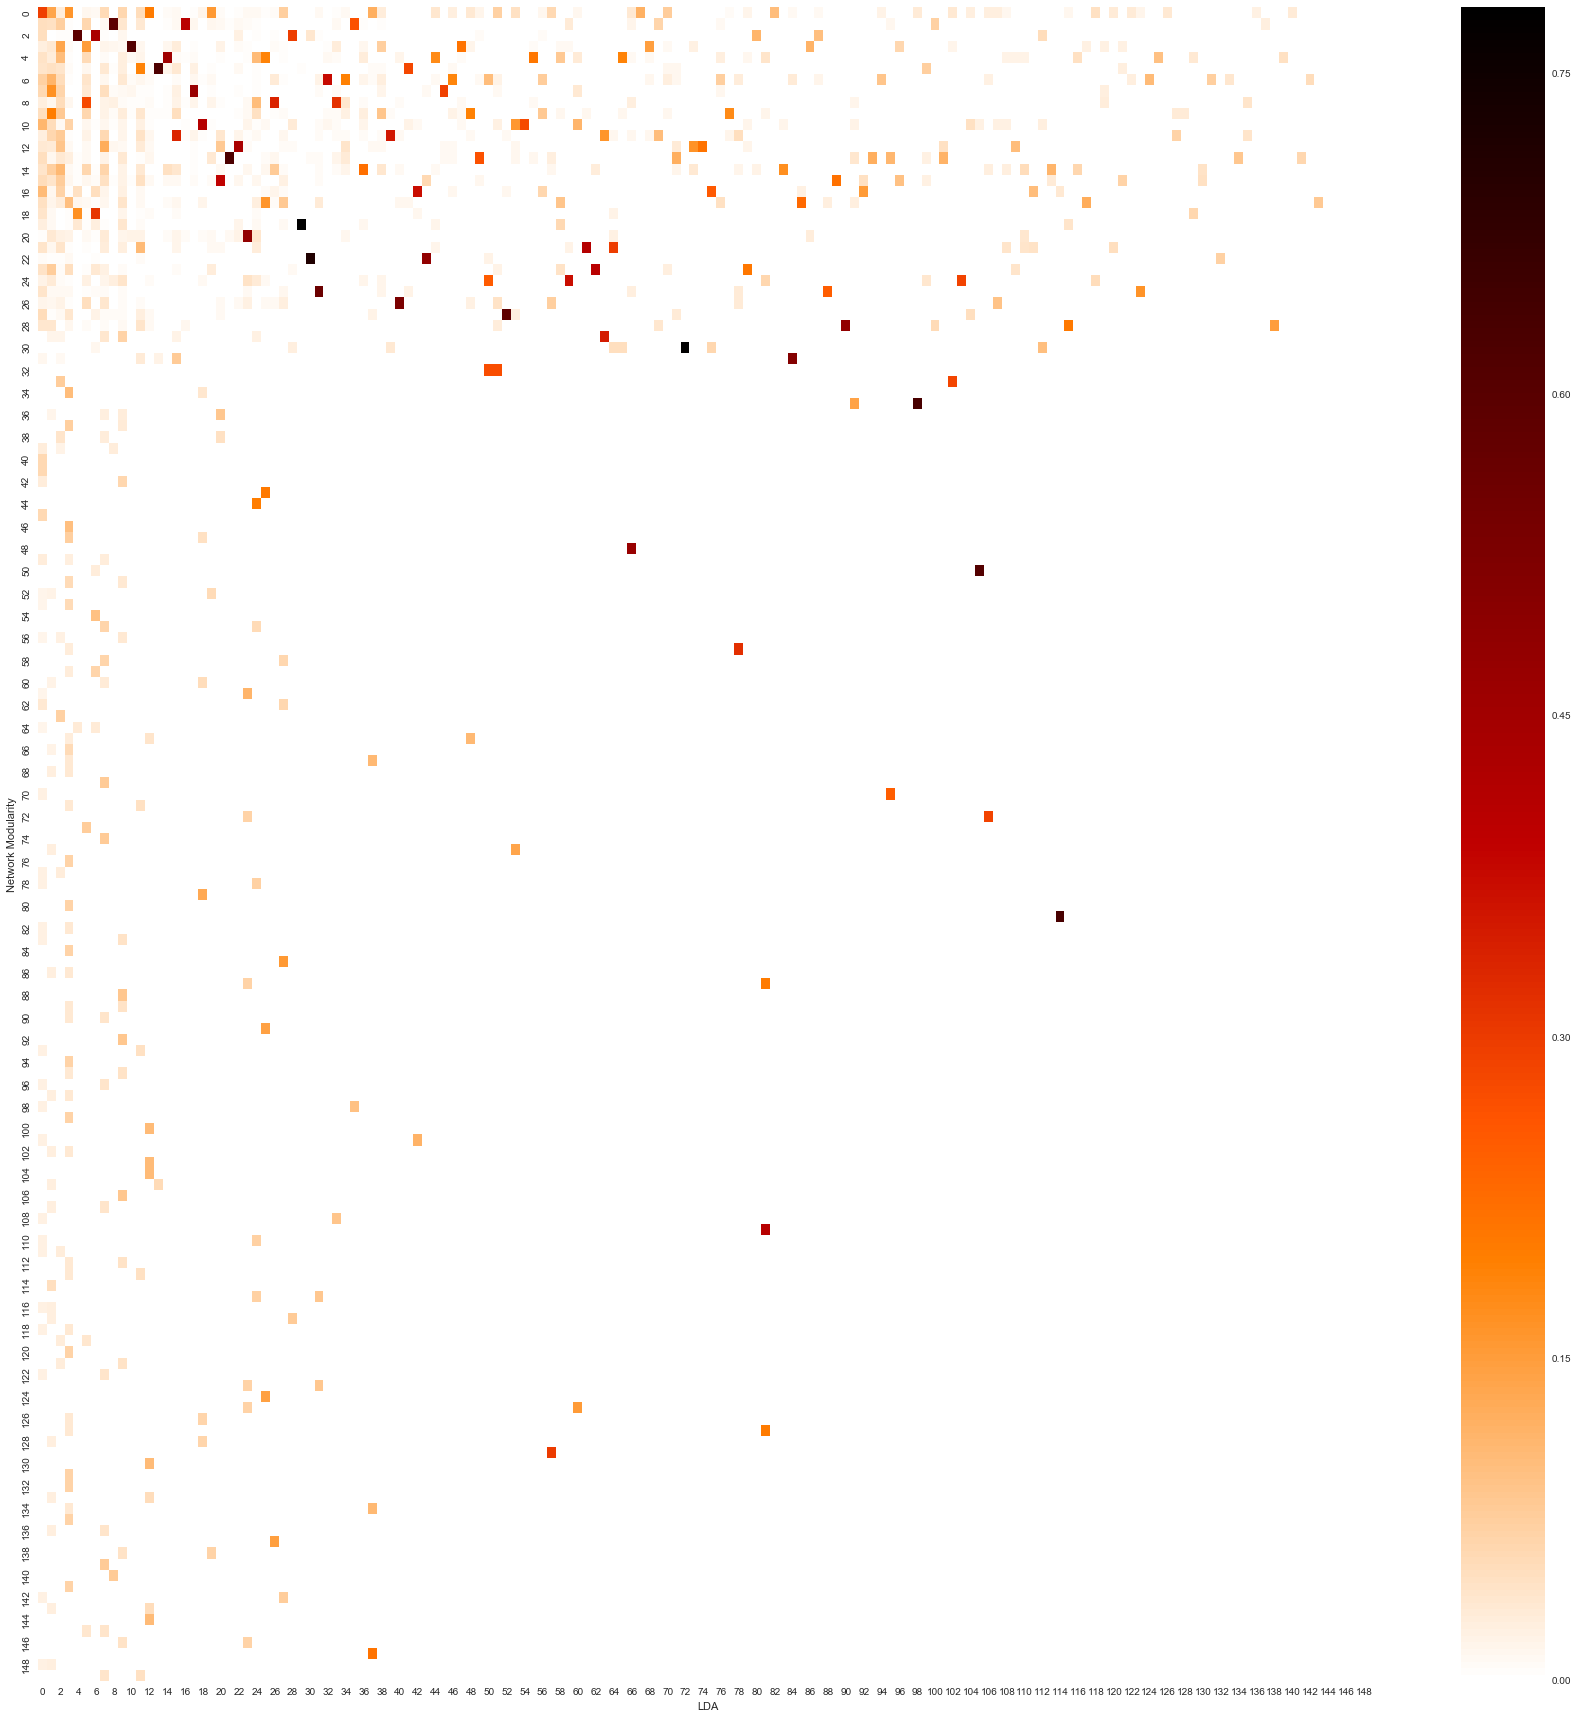

In [104]:
import seaborn as sns

fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(similarities, xticklabels=2, yticklabels=2, cmap=plt.cm.gist_heat_r)
plt.xlabel("LDA")
plt.ylabel("Network Modularity")

# Size to topic table + keywords

In [ ]:
import itertools

def save_keyword_table(topics, file_path):
    result = {}
    for topic in topics:
        items = list(map(lambda x: x.values.tolist(), topic[1]))
        keywords = sorted(list(itertools.chain(*items)), key=lambda x: x[1], reverse=True)
        keywords = list(map(lambda x: x[0], keywords))[:10]
        result[topic[0]] = (len(topic[1]), keywords)
    return result

In [ ]:
def community_to_keywords(com, docs, filename):
    topics = {}

    for i in range(max(com.membership) + 1):
        for v in com.subgraph(i).vs():
            topic_no = i
            try:
                topics[topic_no]
            except KeyError:
                topics[topic_no] = []

            topics[topic_no].append(docs[v['name']]['keywords'])

    topics = sorted(topics.items(), key=lambda x: len(x[1]), reverse=True)

    return save_keyword_table(topics, 'tmp/' + filename)

In [ ]:
# lda_items = pickle.load(open('tmp/count_226_lda_items.pickle', 'rb'))
topics = {}

for k, v in lda_items:
    topic_no = v['lda']
    try:
        topics[topic_no]
    except KeyError:
        topics[topic_no] = []

    topics[topic_no].append(docs[k]['keywords'])
    
topics = sorted(topics.items(), key=lambda x: len(x[1]), reverse=True)

lda_keywords = save_keyword_table(topics, 'tmp/lda_keywordtable.csv')

In [ ]:
net_keywords = community_to_keywords(community, docs, 'network_keywordtable.csv')

In [ ]:
lda_keywords = community_to_keywords(community_lda, docs, 'lda_cosine_keywordtable.csv')

In [ ]:
similarities = pickle.load(open('tmp/similarities.pickle', 'rb'))

In [ ]:
a = similarities[6]
m = max(range(len(a)), key=lambda x: a[x])
m

In [ ]:
import csv

sorted_1 = sorted(net_keywords.items(), key=lambda x: x[1][0], reverse=True)
sorted_2 = sorted(lda_keywords.items(), key=lambda x: x[1][0], reverse=True)

rows = []
for i in range(len(net_keywords)):
    row = [i+1]
    try:
        row += [sorted_1[i][0], sorted_1[i][1][0], sorted_1[i][1][1]]
    except:
        row += ['', '']
        
    try:
        row += [sorted_2[i][0], sorted_2[i][1][0], sorted_2[i][1][1]]
    except:
        row += ['', '']
    
    rows.append(row)
    

with open('tmp/keywords.csv', 'w+') as file:    
    for row in rows:
        writer = csv.writer(file, delimiter=';')
        writer.writerow(row)

In [ ]:
lda_keywords.keys()

In [ ]:
import csv

rows = []
for i, row in enumerate(similarities):
    a = row
    lda =  max(range(len(a)), key=lambda x: a[x])
    sim =  max(a)
    rows.append([i, net_keywords[i][0], net_keywords[i][1], lda, lda_keywords[lda][0], lda_keywords[lda][1], sim])

with open('tmp/matching.csv', 'w+') as file:    
    for row in sorted(rows, key=lambda x: x[1], reverse=True):
        writer = csv.writer(file, delimiter=';')
        writer.writerow(row)

# LCM

In [ ]:
lda_model.minimum_probability=0.0

mat = []
for i, m in enumerate(doc_topic_prob_mat):
    clear_output(wait=True)
    print('{0}\r'.format(i/len(token_keys)))
    a = []
    for n in m:
        if n[1] >= 0.01:
            a.append(n[1])
        else:
            a.append(0)
    mat.append(a)

In [ ]:
len(mat)

In [ ]:
mat_np = np.mat(mat)
pickle.dump(mat, open('tmp/mat.pickle', 'wb'))
mat_np[1]

In [ ]:
from gensim import matutils

def hellinger_similarity(vec1, vec2):
    return 1.0 - matutils.hellinger(np.asarray(vec1), np.asarray(vec2))

In [ ]:
print(hellinger_similarity(mat_np[0], mat_np[1]))

In [ ]:
mat_np = pickle.load(open('tmp/count_226_mat.pickle', 'rb'))
len(mat_np)

## Add LDA to docs

In [ ]:
for i, key in enumerate(token_keys):
    docs[key]['lda_matrix'] = scipy.sparse.csr_matrix(mat_np[i])
  
docs['2016-05-20-28']['lda_matrix']

In [ ]:
g = ig.Graph()
for i, key in enumerate(token_keys):
    g.add_vertices(key)
    
print(g.vcount())

In [ ]:
g.delete_edges(g.es)
edges = []
for i, source in enumerate(token_keys):
    print('{0}\r'.format(i/len(token_keys)))
    for i_2, target in enumerate(token_keys):
        edges.append((source, target))
    clear_output(wait=True)
            
g.add_edges(edges)  
edges = [] 
print(g.ecount())

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

count = 0
for i, source in enumerate(token_keys):
    clear_output(wait=True)
    similarities = cosine_similarity(mat_np[i], mat_np)
    print('{0}\r'.format(i/len(token_keys)))
    for j, target in enumerate(token_keys):  
        g.es[count]["weight"] = similarities[j]
        count += 1

print(g.ecount())

In [ ]:
g.simplify(multiple=True, loops=True, combine_edges="max")
print(g.ecount())

In [ ]:
sg = g.es.select(weight_ge=0.1).subgraph()

In [ ]:
sg.write_gml('tmp/igraph_lda_01.gml')

In [ ]:
print("Nodes {}".format(sg.vcount()))
print("Edges {}".format(sg.ecount()))

## Load LDA Network

In [ ]:
lda_sim = cosine_similarity(mat_np, mat_np)

In [ ]:
g_lda = ig.Graph.Read_GML('tmp/cosine_igraph_lda_01.gml')

In [ ]:
sg_lda = g_lda.es.select(weight_ge=0.9).subgraph()

In [ ]:
print("Nodes {}".format(sg_lda.vcount()))
print("Edges {}".format(sg_lda.ecount()))

In [ ]:
# community = sg.community_infomap(edge_weights='weight')
community_lda = sg_lda.community_multilevel(weights='weight')
# community = sg.community_leading_eigenvector(weights='weight')

In [ ]:
network_properties(sg_lda, community_lda)

In [ ]:
topics = {}

for i in range(max(community_lda.membership) + 1):
    for v in community_lda.subgraph(i).vs():
        topic_no = i
        try:
            topics[topic_no]
        except KeyError:
            topics[topic_no] = []
        topics[topic_no].append(docs[v['name']]['tfidf'])
        
overall_similarity(topics)

In [ ]:
with open('tmp/lda_network_docs.txt', 'w+') as file:
    for i in range(max(community_lda.membership) + 1):
        for v in community_lda.subgraph(i).vs():
            file.write("Topic:{} File:{} Title:{}\n".format(i, v['name'], docs[v['name']]['webTitle']))

In [ ]:
community_to_size_chart(community_lda)

# Hierarchical Clustering

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

dist = 1 - cosine_similarity(mat_np)

In [ ]:
from scipy.cluster.hierarchy import complete, dendrogram

print("Start Hierarchical Clustering...")

linkage_matrix = complete(dist) #define the linkage_matrix using hierachical clustering pre-computed distances

print("Done Hierarchical Clustering...")

In [ ]:
pickle.dump(linkage_matrix, open('tmp/linkage_matrix.pickle', 'wb'))

In [ ]:
linkage_matrix = pickle.load(open('tmp/linkage_matrix.pickle', 'rb'))

In [ ]:
from scipy.cluster.hierarchy import fclusterdata, fcluster

def cluster_indices(cluster_assignments):
    n = cluster_assignments.max()
    indices = []
    for cluster_number in range(1, n + 1):
        indices.append(np.where(cluster_assignments == cluster_number)[0])
    return indices

# Compute the clusters.
cutoff = 1.0
cluster_assignments = fcluster(linkage_matrix, 136, criterion="maxclust")

# Print the indices of the data points in each cluster.
num_clusters = cluster_assignments.max()
print("%d clusters" % num_clusters)
indices = cluster_indices(cluster_assignments)

print("Giant Size:", len(max(indices, key=lambda x: len(x))))

# for k, ind in enumerate(indices):
#     print("cluster", k + 1, " (Length:)", len(ind), "=", ind)

for k, ind in enumerate(indices):
    for i in ind:
        docs[token_keys[i]]['hclust'] = k

In [ ]:
hclust_items = sorted(docs.items(), key=lambda x: x[1]['hclust'])

In [ ]:
with open('tmp/hclust_docs.txt', 'w+') as file:
    for item in hclust_items:
        file.write("Topic:{} File:{} Title:{}\n".format(item[1]['hclust'], item[0], item[1]['webTitle']))

In [ ]:
topics = {}

for k, v in hclust_items:
    topic_no = v['hclust']
    try:
        topics[topic_no]
    except KeyError:
        topics[topic_no] = []

    topics[topic_no].append(docs[k]['tfidf'])

overall_similarity(topics)

In [ ]:
topics = {}

for i in range(num_clusters):
    topics[i] = []
    
for item in hclust_items:
    topic_no = item[1]['hclust']
    topics[topic_no].append(item[0])
    
print(len(topics.keys()))

x_data = []
y_data = []
for key, value in sorted(topics.items(), key=lambda x: len(x[1]), reverse=True):
    x_data.append(key)
    y_data.append(len(value))

ind = np.arange(0, len(y_data) * 2, 2)
fig = plt.figure(figsize=(60,10))
plt.bar(ind, y_data)
plt.xticks(ind, x_data, rotation=90)
plt.title("Topic Document Distribution")
plt.xlabel("Topic")
plt.ylabel("Frequency")
fig.savefig('tmp/size_chart_lda.png')
plt.show()

In [ ]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

In [ ]:
fancy_dendrogram(
    linkage_matrix,
    truncate_mode='lastp',
    p=227,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

# Evaluation

In [16]:
def add_community_to_graph(graph, com):
    for i in range(max(com.membership) + 1):
        for v in com.subgraph(i).vs():
            node = graph.vs().find(name=v['name'])
            node['Community'] = i

In [17]:
import math

def overall_similarity(vectors):
    similarity_topics = {}
    for k, values in vectors.items():
        matx = scipy.sparse.vstack((values))
        similarity_topics[k] = np.sum(cosine_similarity(matx, matx)) / math.pow(len(values), 2)

    return sum(similarity_topics.values()) / len(similarity_topics.values())

## Modularity Network

In [69]:
topics = {}

for i in range(max(community.membership) + 1):
    for v in community.subgraph(i).vs():
        topic_no = i
        try:
            topics[topic_no]
        except KeyError:
            topics[topic_no] = []

        topics[topic_no].append(docs[v['name']]['tfidf'])

In [70]:
print("Overall Similarity {}", overall_similarity(topics))
print("Network Communities Modularity {}".format(sg.modularity(community.membership)))

Overall Similarity {} 0.516244322456
Network Communities Modularity 0.7770162025166544


In [ ]:
topic = topics[0]
print(np.dot((topic[0] + topic[1]).toarray() / len(topic), (topic[0] + topic[1]).toarray().T / len(topic)))

matx = scipy.sparse.vstack((topic))
np.sum(cosine_similarity(matx, matx)) / math.pow(len(topic), 2)

In [ ]:
add_community_to_graph(sg, community)
sg.vs[0]

In [ ]:
sg.write_gml('tmp/network_community.gml')

## LDA

In [39]:
from sklearn.metrics.pairwise import cosine_similarity

similarities = cosine_similarity(lda_vectors, net_vectors)

matching = {}
for i, a in enumerate(similarities):
    b =  max(range(len(a)), key=lambda x: a[x])
    matching[i] = b

print(matching)

NameError: name 'lda_vectors' is not defined

In [ ]:
for v in sg_lda.vs:
    v['Community'] = docs[v['name']]['lda']
sg_lda.vs[0]

In [ ]:
membership = []
for v in sg_lda.vs():
    membership.append(v['Community'])

In [ ]:
print("LDA Communities Modularity {}".format(sg_lda.modularity(membership)))

In [ ]:
for v in sg_lda.vs:
    v['Community'] = matching[v['Community']]

In [ ]:
sg_lda.vs[0]

In [ ]:
sg_lda.write_gml('tmp/lda_community.gml')

In [48]:
# lda_items = pickle.load(open('tmp/count_226_lda_items.pickle', 'rb'))

topics = {}

for k, v in lda_items:
    topic_no = v['lda']
    try:
        topics[topic_no]
    except KeyError:
        topics[topic_no] = []

    topics[topic_no].append(docs[k]['tfidf'])

overall_similarity(topics)

0.26597461367557512

## LCM

In [ ]:
add_community_to_graph(sg_lda, community_lda)
len(sg_lda.vs)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
from collections import defaultdict

similarities = cosine_similarity(lda_vectors, net_vectors)

matching = {}
matching_count = {}
matching_count = defaultdict(lambda: 0, matching_count)

for i, a in enumerate(similarities):
    b =  max(range(len(a)), key=lambda x: a[x])
    if b in matching.values():
        matching_count[b] += 0.1
        matching[i] = b + matching_count[b]
    else:
        matching[i] = b

print(matching)

In [ ]:
for v in sg_lda.vs:
    v['Community'] = matching[v['Community']]

In [ ]:
sg_lda.write_gml('tmp/lda_community.gml')

In [ ]:
topics = {}

for i in range(max(community_lda.membership) + 1):
    for v in community_lda.subgraph(i).vs():
        topic_no = i
        try:
            topics[topic_no]
        except KeyError:
            topics[topic_no] = []
        topics[topic_no].append(docs[v['name']]['tfidf'])
        
overall_similarity(topics)